### MTL with homoscedastic uncertainty: Segmentation, Image Reconstruction, and Boundary Extraction

Imports & Params 

In [11]:
import glob
import os
import pathlib
import sys

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

module_dir = str(pathlib.Path(os.getcwd()).parent)
sys.path.append(module_dir)

%load_ext autoreload
%autoreload 2

import skimage.io
import numpy as np
import torch
from torch.utils.data import DataLoader

import params as pm
from base import *
from dataset import (SemSeg_Custom, get_training_augmentation,
                     get_val_augmentation, get_test_augmentation, to_tensor)
from encoders import *
from utilities import (convert_from_color, convert_to_color, get_id,
                       visualize)
from utils import *
from evaluate import evaluate,calculate_metrics 
from unet import model

params = pm.get_params()

# ensure reproducibility
torch.manual_seed(params['seed'])
np.random.seed(params['seed'])
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

params

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{'experiment_log': 'MTL_ser_r101u_0',
 'main_dir': 'C:\\Users\\burak\\Desktop',
 'log_path': 'C:\\Users\\burak\\Desktop\\mtl\\logs',
 'main_data_dir': 'D:\\Veri-Setleri\\SN6\\SN6_buildings_AOI_11_Rotterdam_train\\train\\AOI_11_Rotterdam',
 'masks_dir': 'D:\\Veri-Setleri\\SN6\\SN6_buildings_AOI_11_Rotterdam_train\\train\\AOI_11_Rotterdam\\MASKS_binary',
 'psp_dir': 'D:\\Veri-Setleri\\SN6\\SN6_buildings_AOI_11_Rotterdam_train\\train\\AOI_11_Rotterdam\\PS-RGB',
 'crop_size': (480, 480),
 'encoder': 'resnet101',
 'encoder_weights': 'imagenet',
 'classes': array([0, 1]),
 'activation': 'sigmoid',
 'device': device(type='cuda'),
 'batch_size': 4,
 'lr': 0.0001,
 'n_epoch': 50,
 'n_workers': 0,
 'seed': 12}

Datasets and Loaders

In [3]:
train_dataset = SemSeg_Custom(masks_dir=params['masks_dir'],
                                  psp_dir = params['psp_dir'],  
                                  mode='train',
                                  augmentation= get_training_augmentation(params['crop_size']),
                                  image_mask= False)

train_loader = DataLoader(dataset=train_dataset,
                              batch_size= params['batch_size'],
                              shuffle=True,
                              num_workers=params['n_workers'],
                              pin_memory=True,
                              prefetch_factor=2,
                              persistent_workers=False)
                          
valid_dataset = SemSeg_Custom(masks_dir=params['masks_dir'],
                                  psp_dir = params['psp_dir'], 
                                  mode='validation',
                                  augmentation=get_val_augmentation(params['crop_size']),
                                  image_mask= False) 
 
valid_loader = DataLoader(dataset=valid_dataset,
                              batch_size= params['batch_size'],
                              shuffle=False,
                              num_workers=params['n_workers'],
                              pin_memory=True,
                              prefetch_factor=2,
                              persistent_workers=False)

test_dataset = SemSeg_Custom(masks_dir=params['masks_dir'],
                                  psp_dir = params['psp_dir'], 
                                  mode='test',
                                  augmentation= get_test_augmentation(params['crop_size']),
                                  image_mask= False) 
 
test_loader = DataLoader(dataset=test_dataset,
                              batch_size= params['batch_size'],
                              shuffle=False,
                              num_workers=params['n_workers'],
                              pin_memory=True,
                              prefetch_factor=2,
                              persistent_workers=False)

inference_dataset = SemSeg_Custom(masks_dir=params['masks_dir'],
                                  psp_dir = params['psp_dir'], 
                                  mode='test',
                                  augmentation= get_test_augmentation(params['crop_size']),
                                  image_mask= False,
                                  inference = True) 

Len train_ids: 2451, Len val_ids 680, Len test_ids 340
Len train_ids: 2451, Len val_ids 680, Len test_ids 340
Len train_ids: 2451, Len val_ids 680, Len test_ids 340
Len train_ids: 2451, Len val_ids 680, Len test_ids 340


Sanity check

torch.Size([3, 480, 480]) torch.Size([2, 480, 480]) torch.Size([2, 480, 480])
(480, 480, 3) (480, 480, 2) (480, 480, 2)


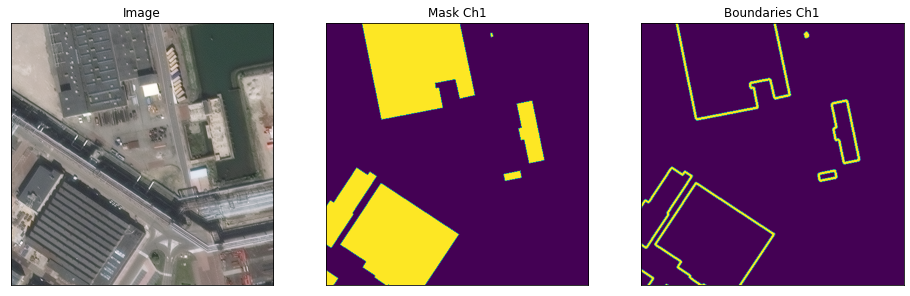

In [4]:
sample_idx = np.random.randint(len(test_dataset))
image1, mask1, boundary_mask1 = test_dataset[sample_idx]
print(image1.shape, mask1.shape, boundary_mask1.shape)

image = np.asarray(image1).transpose(1,2,0)
mask = np.asarray(mask1).transpose(1,2,0)
boundary_mask = np.asarray(boundary_mask1).transpose(1,2,0)
print(image.shape, mask.shape, boundary_mask.shape)

visualize(Image= image,
          mask_ch1 = mask[:,:,0], #first channel is bulding, second one is background.
          boundaries_ch1 = boundary_mask[:,:,0])

UNet and its components 

In [5]:
model = model.Unet(encoder_name=params['encoder'], 
                    encoder_weights=params['encoder_weights'], 
                    classes=len(params['classes']), 
                    activation=params['activation'])

model = model.cuda()

loss = losses.MultiTaskLoss(model)

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=params['lr']),
])


metrics = [
   metrics.IoU(threshold=0.5),
   metrics.Fscore(beta = 1),
   metrics.Precision(),
   metrics.Recall()
]

Pretrained.
MTL_learnable: Segmentation + Boundary + Reconstruction


Training

In [ ]:
train_epoch = train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    verbose=True,
    device = params['device']
)

valid_epoch = train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    verbose=True,
    device = params['device']
)

max_score = 0

for i in range(0, params['n_epoch']-1):    
    print('\nEpoch: {}'.format(i + 1))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, os.path.join(params['log_path'],
         '.\{}.pth'.format(params['experiment_log'])))
        print('Model saved!')

Inference

In [6]:
best_model = torch.load(os.path.join(params['log_path'],'.\{}.pth'.format(params['experiment_log'])))
best_model.cuda()
print("done")

done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


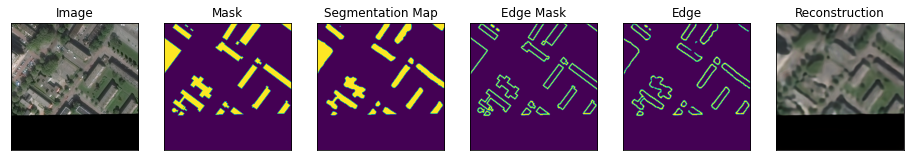

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


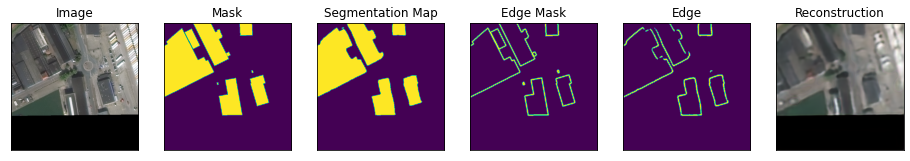

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


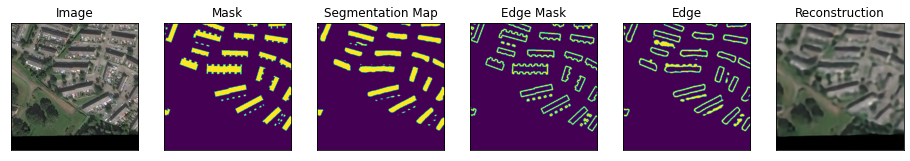

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


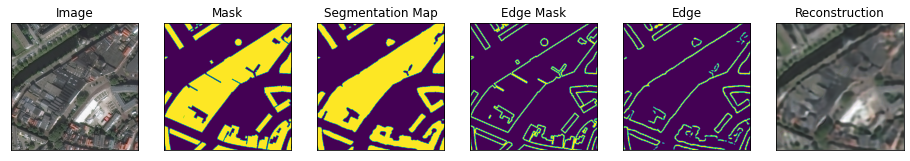

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


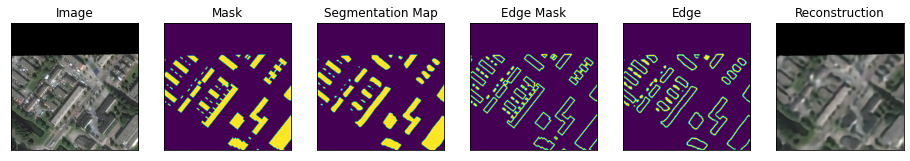

In [7]:
for i in range(5):
    sample_idx = np.random.randint(len(test_dataset))
    image, mask, edge_mask = test_dataset[sample_idx[i]]

    image = np.asarray(image).transpose(1,2,0)
    mask = np.asarray(mask).transpose(1,2,0)
    edge_mask = np.asarray(edge_mask).transpose(1,2,0)

    segmentation, edge, reconstruction = best_model.predict(torch.tensor(np.expand_dims(np.transpose(image,(2,0,1)), axis = 0), device = 'cuda'))

    segmentation = np.transpose(segmentation.squeeze().detach().cpu().numpy(),(1,2,0)).round()
    edge = np.transpose(edge.squeeze().detach().cpu().numpy(),(1,2,0))
    reconstruction = np.transpose(reconstruction.squeeze().detach().cpu().numpy(),(1,2,0))

    trsh = edge.max() / 2
    edge[edge >= trsh] = 1
    edge[edge < trsh] = 0

    visualize(image = image,
              mask = mask[:,:,0],
              segmentation_Map = segmentation[:,:,0],
              edge_mask = edge_mask[:,:,0],
              edge = edge[:,:,0],
              reconstruction = reconstruction)

Evaluation 

In [8]:
from evaluate import calculate_metrics, evaluate

y_preds, ys = evaluate(best_model, test_dataset)

100%|████████████████████████████████████████████████████████████████████████████████| 340/340 [00:50<00:00,  6.77it/s]


In [9]:
f1, prec, rec, jacc, acc = calculate_metrics(y_preds, ys)

In [10]:
print("-----f1---------prec---------rec---------jacc")
print("",np.stack([f1, prec, rec, jacc], axis=-1))
print("-----acc-----")
print(acc)

-----f1---------prec---------rec---------jacc
 [[0.90904844 0.92684677 0.8919208  0.83326197]
 [0.99164139 0.98989442 0.99339453 0.98342135]]
-----acc-----
0.9846898105596406


end